In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [2]:
%matplotlib inline

import os
import sys
import inspect
import shutil

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

from tools import print_progress, array_in, create_input_data

In [3]:
# create a function of x that returns random samples around a*x+b
def make_lin(a, b, rnd):
    def _f_a(x):
        mu = a*x + b
        return rnd(mu)
    return _f_a

In [4]:
f_a = make_lin(2, 1, lambda mu: np.random.normal(loc=mu, scale=1.0))
f_b = make_lin(-.5, -1.5, lambda mu: np.random.normal(loc=mu, scale=1.0))

In [5]:
try:
    sess.close()
except:
    print("OK. Was already closed or didn't exist. That's fine.")
    
sess = tf.InteractiveSession()

OK. Was already closed or didn't exist. That's fine.


In [6]:
# create a function of x that returns random samples around a constant, if the hour of week 
conditions = np.array([
    (0, 18), (0, 19), (0, 20), (0, 21), # Mondays
    (1, 18), (1, 19), (1, 20), (1, 21), # Tuesdays
    (2, 18), (2, 19), (2, 20), (2, 21), # Wednesdays
    # closed on Thursdays
    (4, 14), (4, 15), (4, 16),          # Fridays
    (5, 14), (5, 15), (5, 16)           # Saturdays
    # closed on Sundays
    ])

def make_noisy_amplitude_function(amplitude):
    def _f(c1, c2):
        zipped = zip(c1,c2)
        res = array_in(zipped, conditions)        
        return res * (np.random.normal( 0 * res, .2 ) + amplitude)
    return _f

In [7]:
def create_data_frame(size, amplitude=5.0):
    x_data = np.random.uniform(high=5, low=-5, size=size)
    y_data = np.random.uniform(high=5, low=-5, size=size)
    dow_data = np.random.randint(7, size=size)
    hod_data = np.random.randint(24, size=size)
    f_data = f_a(x_data) + f_b(y_data)
    
    f_special = make_noisy_amplitude_function(amplitude)(dow_data, hod_data)

    f_total = f_data + f_special
    f_perf = -.5 * y_data - 1.5 + 2 * x_data + 1
    df = pd.DataFrame({'x': x_data, 'y': y_data, 'dow': dow_data, 'hod': hod_data, 'f_orig': f_data, 'p': f_perf, 'special': f_special, 'f': f_total})
    return df

In [8]:
def create_data(size, amplitude):
    df = create_data_frame(size = size, amplitude=amplitude)
    input_data = create_input_data(df=df, select_feats=['x', 'y'], cross_feats=[{'dow': 7, 'hod': 24}])    
    lbls_data = [list(df['f'])]
    return input_data, lbls_data, df

In [9]:
NUM_RECORDS = 20000
LIN_DIM = 2
CAT_DIM = 168
EMB_DIM = 3
LEARNING_RATE = .05
LOG_DIR = 'logs'

The weights, including the embedding weights - and the bias

In [10]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stdev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stdev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [11]:
def weight_variable(name, shape):
    init_with = tf.truncated_normal(shape, stddev=.1)
    with tf.name_scope(name):
        var = tf.Variable(init_with)
        variable_summaries(var)
    return var

In [12]:
def bias_variable(name, shape=[]):
    init_with = tf.constant(0.1, shape=shape)
    with tf.name_scope(name):
        var = tf.Variable(init_with)
        variable_summaries(var)
    return var

In [13]:
M_emb = weight_variable('M_emb', shape=(EMB_DIM, CAT_DIM))
M_lin = weight_variable('M_lin', shape=(1, LIN_DIM + EMB_DIM))
b = bias_variable('bias')

In [14]:
#M_emb = tf.Variable(tf.random_normal(shape=(EMB_DIM, CAT_DIM)))
#M = tf.Variable(tf.zeros(shape=(1, LIN_DIM + EMB_DIM)))
#b = tf.Variable(0.)

In [15]:
tf.summary.histogram('embeddings', M_emb)

<tf.Tensor 'embeddings:0' shape=() dtype=string>

The place holders

In [16]:
x_lin = tf.placeholder(shape=(LIN_DIM, None), dtype=tf.float32)
x_cat = tf.placeholder(shape=(CAT_DIM, None), dtype=tf.float32)
lbls = tf.placeholder(shape=(1,None), dtype=tf.float32)

The input data: embed categorical sparse data and concatenate with linear features

In [17]:
x_emb = tf.matmul(M_emb, x_cat)
x = tf.concat([x_lin, x_emb], axis=0)

The hypothesis and the loss

In [18]:
f = tf.matmul(M_lin, x) + b
d = tf.losses.mean_squared_error(lbls, f)
tf.summary.scalar('mse', d)

<tf.Tensor 'mse:0' shape=() dtype=string>

The gradients and the optimizers, now including the embedding matrix

In [19]:
nMl = tf.gradients(d, M_lin)
nb = tf.gradients(d, b)
nMe = tf.gradients(d, M_emb)
aMl = tf.assign_add( M_lin, tf.multiply(nMl[0], -LEARNING_RATE))
ab = tf.assign_add( b, tf.multiply(nb[0], -LEARNING_RATE))
aMe = tf.assign_add( M_emb, tf.multiply(nMe[0], -LEARNING_RATE))

In [20]:
all_summaries = tf.summary.merge_all()

In [21]:
init = tf.global_variables_initializer()
sess.run(init)

Clean file system and initialize variables

In [22]:
shutil.rmtree(LOG_DIR, ignore_errors=True)
writer = tf.summary.FileWriter(os.path.join(LOG_DIR, 'train'), sess.graph)

In [23]:
input_data, lbls_data, _ = create_data(size = NUM_RECORDS, amplitude=10.0)
feed_dict = {
   x_lin: input_data[:2], 
   x_cat: input_data[2:], 
   lbls: lbls_data
}

Now, please observe how fast the loss converges!

In [24]:
for i in range(300):    
    loss, summaries, _, _, _  = sess.run([d, all_summaries, aMl, ab, aMe], feed_dict=feed_dict)
    writer.add_summary(summaries, i)    
    print_progress("- Loss: {}", loss)

writer.close()

- Loss: 1.9998234510421753

---
Now let's examine the error distribution on some test data once more

In [25]:
input_data_test, lbls_data_test, df = create_data(size = 20000, amplitude=10.0)

In [26]:
preds = sess.run(f, feed_dict={
    x_lin: input_data_test[:2], 
    x_cat: input_data_test[2:]})

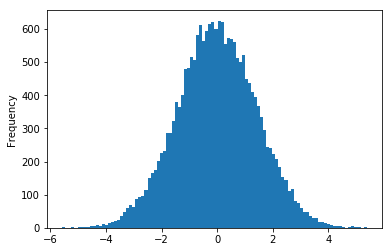

In [27]:
errors = preds[0] - lbls_data_test[0]
df['preds'] = preds[0]
df['err'] = errors
df['err'].plot.hist(bins=100);

---
Now let's look at the embedded vectors

In [30]:
embs = sess.run([x_emb], feed_dict={x_cat: input_data_test[2:]})

In [31]:
embs_pd = pd.DataFrame(np.transpose(embs[0]))

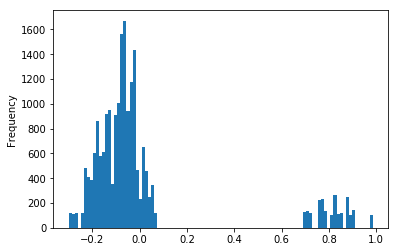

In [32]:
embs_pd[1].plot.hist(bins=100);

We can only assume that the values form two distinct clusters in the embedding space. We suspect that the smaller cluster is made of those dry-cleaner's peek hours.

In [30]:
print(conditions.tolist())

[[0, 18], [0, 19], [0, 20], [0, 21], [1, 18], [1, 19], [1, 20], [1, 21], [2, 18], [2, 19], [2, 20], [2, 21], [4, 14], [4, 15], [4, 16], [5, 14], [5, 15], [5, 16]]
